In [5]:
# Import necessary libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Enable inline plotting for notebooks
%matplotlib inline

In [6]:
def rgb2gray(image_array):
    """
    Convert an RGB image (as a NumPy array) to grayscale.
    """
    return np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

def sobel_gradients(gray_image):
    """
    Compute the gradient magnitude using a Sobel operator.
    """
    # Define Sobel kernels
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]], dtype=np.float32)
    
    H, W = gray_image.shape
    # Pad the image to handle borders
    padded = np.pad(gray_image, ((1, 1), (1, 1)), mode='edge')
    Gx = np.zeros_like(gray_image, dtype=np.float32)
    Gy = np.zeros_like(gray_image, dtype=np.float32)
    
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+3, j:j+3]
            Gx[i, j] = np.sum(Kx * patch)
            Gy[i, j] = np.sum(Ky * patch)
    
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)
    return grad_magnitude

def compute_edge_confidence(pil_image, edge_threshold=50, window_size=20):
    """
    Computes an edge-based confidence score indicating the likelihood of an animal presence.
    
    Parameters:
      - pil_image: A PIL Image object.
      - edge_threshold: Threshold on gradient magnitude for edge detection.
      - window_size: Size of the sliding window to capture local edge blobs.
    
    Returns:
      - confidence: A value between 0 and 1.
      - edge_map: The binary edge image (for debugging/visualization).
    """
    # Convert the PIL image to grayscale (as a NumPy array)
    gray_array = np.array(pil_image.convert('L'), dtype=np.float32)
    
    # Compute the gradient magnitude
    grad_mag = sobel_gradients(gray_array)
    
    # Create a binary edge map: pixels above edge_threshold are set to 1
    edge_map = (grad_mag > edge_threshold).astype(np.uint8)
    
    # Global edge fraction: ratio of edge pixels to total pixels
    edge_fraction = np.sum(edge_map) / edge_map.size
    
    # Look for a large blob by scanning with a sliding window
    H, W = edge_map.shape
    max_blob = 0
    for i in range(0, H - window_size + 1, window_size):
        for j in range(0, W - window_size + 1, window_size):
            window = edge_map[i:i+window_size, j:j+window_size]
            blob_sum = np.sum(window)
            if blob_sum > max_blob:
                max_blob = blob_sum
    blob_fraction = max_blob / (window_size * window_size)
    
    # Combine both metrics to get a confidence score
    confidence = (edge_fraction + blob_fraction) / 2.0
    return confidence, edge_map


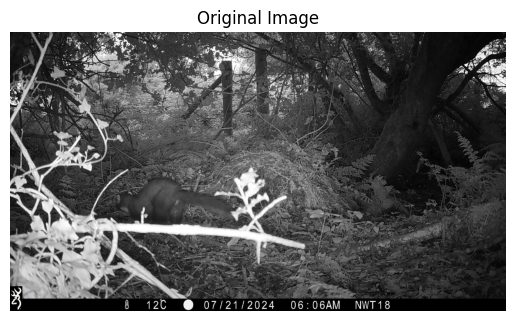

In [7]:
# Load a sample image using PIL
sample_image_path = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0198.JPG"  # Update with your image path
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()
